In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Distributions import Uniform
from UQpy.SampleMethods import MCS, LHS
from UQpy.Surrogates import ErrorEstimation
from UQpy.Sensitivity import SobolGPR
import scipy.stats as stats
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn import preprocessing

Ishigami function:

$$ Y = \sin(X_1) + 7 \sin(X_2)^2 + 0.1 X_3^4 \sin(X_1)$$

such that $X_i \sim Uniform(-\pi, \pi)$  $\forall i \in \{1, 2, 3\}$

In [2]:
def ishigami(x):
    return np.sin(x[:, 0]) + 7*np.sin(x[:, 1])**2 + 0.1*(x[:, 2]**4)*np.sin(x[:, 0])

Sobol Indices:

$$ S_1 = 0.3139 \quad \quad \quad S_2 = 0.4424 \quad \quad \quad S_3 = 0.$$ 

Interaction terms:
$$ S_{12} = 0. \quad \quad \quad S_{13} = 0.2437 \quad \quad \quad S_{23} = 0.$$ 

In [3]:
input_dimension = 3
true_si = [0.3139, 0.4424, 0]
marginals = [Uniform(loc=-np.pi, scale=2*np.pi)]*input_dimension

In [4]:
lhs = LHS(dist_object=marginals, nsamples=100, random_state=10)
samples = lhs.samples.copy()

In [5]:
values = ishigami(samples).reshape(-1, 1)

In [6]:
kernel = ConstantKernel(constant_value_bounds=(1e-2, 5)) * RBF(length_scale=[0.5] * input_dimension,
                                                                 length_scale_bounds=(0.01, 3))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)

In [7]:
training_x = samples.copy()
training_y = values.copy()
transform_x = preprocessing.StandardScaler().fit(training_x)
transform_training_x = transform_x.transform(training_x)

transform_y = preprocessing.StandardScaler().fit(training_y)
transform_training_y = transform_y.transform(training_y)

In [8]:
gpr.fit(transform_training_x, transform_training_y)
print('GPR hyperparameters: ', gpr.kernel_.k2)

GPR hyperparameters:  RBF(length_scale=[1.31, 0.716, 0.975])


In [9]:
test_samples = MCS(dist_object=marginals, nsamples=50, random_state=1).samples
test_values = ishigami(test_samples).reshape(-1, 1)

In [10]:
# Compute Validation Error using UQpy
err = ErrorEstimation(surr_object=gpr)
print('Validation Error: ', round(err.validation(transform_x.transform(test_samples), transform_y.transform(test_values)), 4))

Validation Error:  0.1004


In [11]:
si = SobolGPR(surr_object=gpr, dist_object=marginals, random_state=0, nrandv=400, lower_bound=0, upper_bound=1, 
              transform_x=transform_x, transform_y=transform_y)
si.run(samples=samples)

(Total variance) MCS estimate:  12.586002300106408
Sobol Indices (using MCS estimate of variance):  [0.28818140034728074, 0.4737663473453166, 0.017152388450532102]


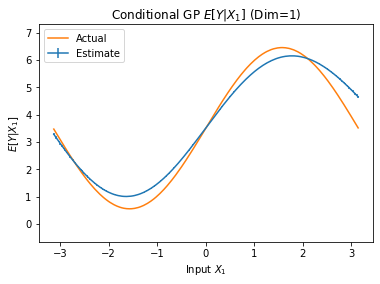

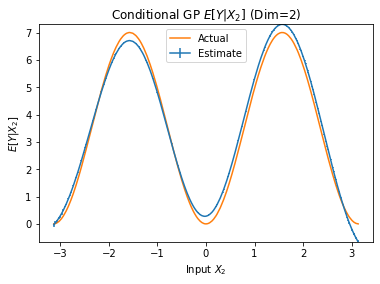

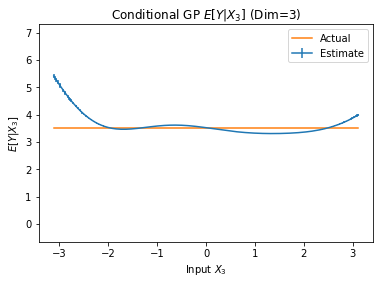

In [12]:
def f1(x):
    return np.sin(x)*(np.pi**4/50+1)+3.5
    
def f2(x):
    return 7*np.sin(x)**2
    
def f3(x3):
    return [3.5]*x3.shape[0]

si.plot_conditional_gp(actual_function=[f1, f2, f3], err_bar=1)

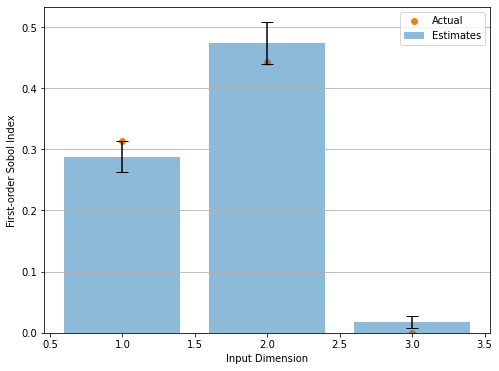

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(np.arange(3)+1, si.sobol_mean, yerr=si.sobol_std, label='Estimates', capsize=6, alpha=0.5)
ax.scatter(np.arange(3)+1, true_si, label='Actual')
plt.xlabel('Input Dimension')
plt.ylabel('First-order Sobol Index')
ax.yaxis.grid(True)
plt.legend()
plt.show()

In [14]:
int_mean, s_ij_mean, s_ij_std = si.run_interaction()

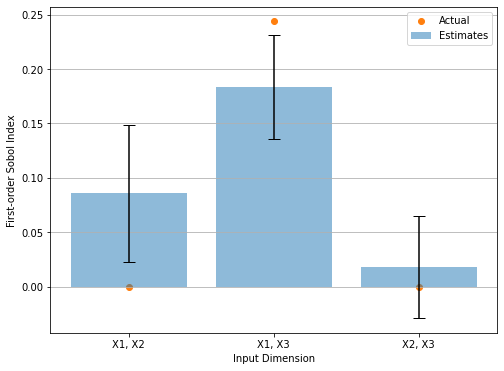

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
labels = ['X1, X2', 'X1, X3', 'X2, X3']
ax.bar(np.arange(3)+1, s_ij_mean[np.triu_indices(3, k = 1)], yerr=s_ij_std[np.triu_indices(3, k = 1)], 
       label='Estimates', capsize=6, alpha=0.5)
ax.scatter(np.arange(3)+1, [0, 0.2437, 0], label='Actual')
ax.set_xticks(np.arange(3)+1)
ax.set_xticklabels(labels)
plt.xlabel('Input Dimension')
plt.ylabel('First-order Sobol Index')
ax.yaxis.grid(True)
plt.legend()
plt.show()

In [16]:
int_mean.keys()

dict_keys(['01', '02', '12'])

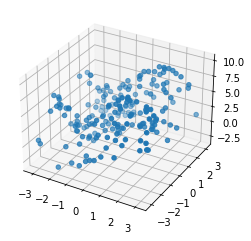

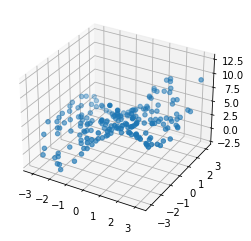

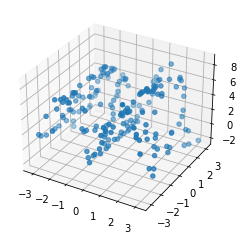

In [17]:
for i in range(input_dimension):
    for j in range(i+1, input_dimension):
        sample_ij = si.discrete_samples[:, (i, j)]
        y_ij = si._inverse_transform_y(int_mean['{}{}'.format(i, j)])
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter(sample_ij[:, 0], sample_ij[:, 1], y_ij)
        plt.show()